## Installations and Imports :



In [ ]:
!pip install sklearn librosa mir_eval tensorflow

In [2]:
#!/usr/bin/env python3
import argparse

from numpy.lib.npyio import save
from Models import MLP, MLP_scalered, CRNN, CRNN_1
from Datasets import IsophonicsDataset 
import sklearn
import sys

In [3]:
#!/usr/bin/env python3
parser = argparse.ArgumentParser()
# Directories, destinations, folders, files
parser.add_argument("--isophonics_audio_directory", default="./Datasets/Isophonics/AUDIO", type=str, help="Path to ISOPHONICS directory with audio files.")
parser.add_argument("--isophonics_annotations_directory", default="./Datasets/Isophonics/ANNOTATIONS", type=str, help="Path to ISOPHONICS directory with chord annotations.")
parser.add_argument("--billboard_audio_directory", default="./Datasets/Billboard/AUDIO", type=str, help="Path to BILLBOARD directory with audio files.")
parser.add_argument("--billboard_annotations_directory", default="./Datasets/Billboard/ANNOTATIONS", type=str, help="Path to BILLBOARD directory with chord annotations.")
parser.add_argument("--isophonics_prep_dest", default="./PreprocessedDatasets/isophonics_new.ds", type=str, help="Preprocessed ISOPHONICS dataset destination.")
parser.add_argument("--billboard_prep_dest", default="./PreprocessedDatasets/billboard_new.ds", type=str, help="Preprocessed BILLBOARD dataset destination.")

# Dataset preprocessing args
parser.add_argument("--dataset", default="isophonics", type=str, help="Dataset we want to preprocess, {isophonics, billboard}")
#           Isophonics
parser.add_argument("--sample_rate", default=44100, type=int, help="Sample rate for each song.")
parser.add_argument("--hop_length", default=512, type=int, help="10*(sample_rate/hop_length) is a number of miliseconds between two frames.")
parser.add_argument("--window_size", default=8, type=int, help="Spectrograms on left, and also spectrogram on right of the time bin -> window_size*2 + 1 spectrograms grouped together.")
parser.add_argument("--flattened_window", default=False, type=bool, help="Whether the spectrogram window should be flatten to one array or it sould be array of spectrograms.")
parser.add_argument("--ms_intervals", default=430.6640625, type=float, help="Miliseconds between generated spectrograms.")
parser.add_argument("--to_skip", default=10, type=int, help="How many spectrogram we want to skip when creating spectrogram window.")
parser.add_argument("--norm_to_C", default=True, type=bool, help="Whether we want to transpose all songs to C key (or D dorian, .. A minor, ...)")
parser.add_argument("--spectrogram_type", default="cqt", type=str, help="Spectrogram types, {cqt,log_mel}")
#           Billboard
parser.add_argument("--n_frames", default=1000, type=int, help="Length of song subsequence we are consinder when predicting chords to keep some context.")

# Training args
parser.add_argument("--test_size", default=0.3, type=lambda x:int(x) if x.isdigit() else float(x), help="Test set size.")
parser.add_argument("--epochs", default=100, type=int, help="Number of epochs.")
parser.add_argument("--seed", default=42, type=int, help="Random seed.")


args = parser.parse_args([] if "__file__" not in globals() else None)

# ISOPHONICS DATASET 

## MLP with scaler preprocessing (and all songs in C major key)

[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
[INFO] The MLP model with scaler preprocessing was successfully created.
[INFO] The MLP model was successfully trained.

 Dev accuracy:  50.68 % 



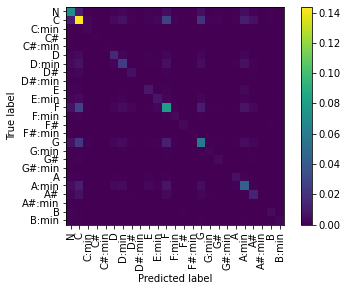

In [ ]:
#!/usr/bin/env python3
# hop length 22050, sample rate 44100, flattened, window size 5, normalized to C major, skip 1
# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("./PreprocessedDatasets/isophonics_5_true_500_1_true.ds")
train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=args.test_size, random_state=args.seed)

# Create model
mlp_model = MLP_scalered(random_state=7)

# Train model
mlp_model.fit(train_x, train_y)

# Display score
print("\n","Dev accuracy: ", "{:.2f}".format(100*mlp_model.score(dev_x, dev_y)), "%", "\n")
mlp_model.display_confusion_matrix(dev_x, dev_y)

## CRNN model, CQT 
*sample rate 22050, hop_length 512, 1000 frames*

[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1000, 252, 16)     160       
_________________________________________________________________
batch_normalization (BatchNo (None, 1000, 252, 16)     64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1000, 252, 16)     2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 252, 16)     64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1000, 252, 16)     2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000, 252, 16)     64        
______________________________________________________

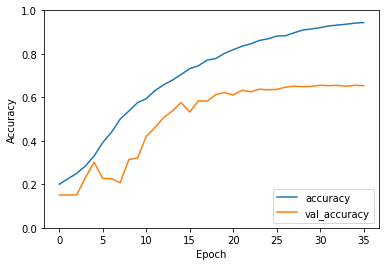

17/17 - 91s - loss: 1.2689 - accuracy: 0.6535

 Dev accuracy:  65.35 % 



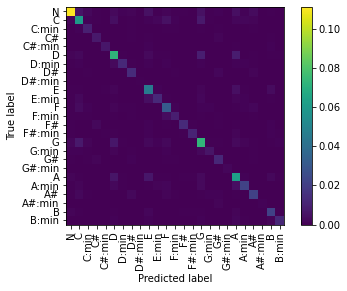

In [ ]:
#!/usr/bin/env python3
# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("./drive/MyDrive/Isophonics1000.ds")
n_samples, n_frames, n_chromas = x.shape
x = x.reshape((n_samples,n_frames,n_chromas,1))
train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=0.3, random_state=args.seed)
 
# Create model
crnn_model = CRNN_1(input_shape=(n_frames, n_chromas, 1), output_classes=25)
 
# Train model
crnn_model.fit(train_x, train_y, dev_x, dev_y, epochs=36)
 
# Display score
crnn_model.display_training_progress()
print("\n","Dev accuracy: ", "{:.2f}".format(100*crnn_model.score(dev_x, dev_y)), "%", "\n")
crnn_model.display_confusion_matrix(dev_x, dev_y)

## Basic model, data transposed to C major key (and its modes .. dorian, phrygian, ...)


[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
[INFO] The MLP model was successfully created.
[INFO] The MLP model was successfully trained.

 Dev accuracy:  43.12 % 



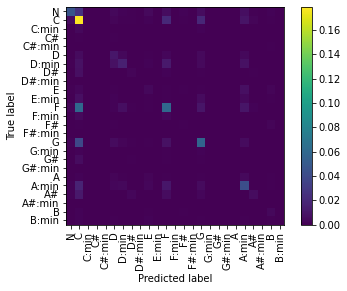

In [ ]:
#!/usr/bin/env python3

# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("./PreprocessedDatasets/isophonics_5_true_500_1_true.ds")
train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=args.test_size, random_state=args.seed)

# Create model
mlp_model = MLP(random_state=7)

# Train model
mlp_model.fit(train_x, train_y)

# Display score
print("\n","Dev accuracy: ", "{:.2f}".format(100*mlp_model.score(dev_x, dev_y)), "%", "\n")
mlp_model.display_confusion_matrix(dev_x, dev_y)

## Basic models, all data transposed to C key

[INFO] The Dataset was loaded successfully.
[INFO] The MLP model was successfully created.
[INFO] The MLP model was successfully trained.

 Dev accuracy:  41.97 % 



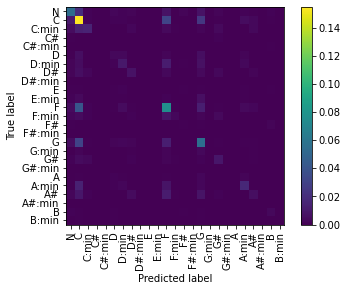

In [ ]:
#!/usr/bin/env python3

# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("./PreprocessedDatasets/isophonics_5_true_500_1_true-everything_to_C.ds")
train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=args.test_size, random_state=args.seed)

# Create model
mlp_model = MLP()

# Train model
mlp_model.fit(train_x, train_y)

# Display score
print("\n","Dev accuracy: ", "{:.2f}".format(100*mlp_model.score(dev_x, dev_y)), "%", "\n")
mlp_model.display_confusion_matrix(dev_x, dev_y)

## Basic MLP model

[INFO] The Dataset was loaded successfully.
[INFO] The MLP model was successfully created.
[INFO] The MLP model was successfully trained.

 Dev accuracy:  27.31 % 



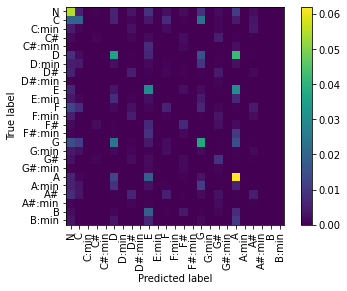

In [ ]:
#!/usr/bin/env python3

# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("./PreprocessedDatasets/isophonics_5_true_500_1.ds")
train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=args.test_size, random_state=args.seed)

# Create model
mlp_model = MLP()

# Train model
mlp_model.fit(train_x, train_y)

# Display score
print("\n","Dev accuracy: ", "{:.2f}".format(100*mlp_model.score(dev_x, dev_y)), "%", "\n")
mlp_model.display_confusion_matrix(dev_x, dev_y)

# BILLBOARD DATASET

## CNN, RNN model, chroma NNLS features

[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 500, 24, 16)       160       
_________________________________________________________________
batch_normalization (BatchNo (None, 500, 24, 16)       64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 500, 24, 16)       2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 24, 16)       64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 500, 24, 16)       2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 500, 24, 16)       64        
______________________________________________________

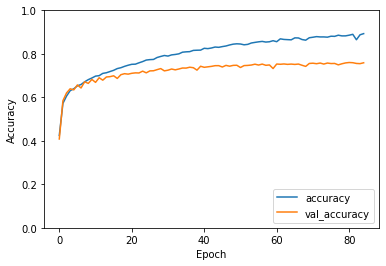

82/82 - 2s - loss: 0.9023 - accuracy: 0.7589

 Dev accuracy:  75.89 % 



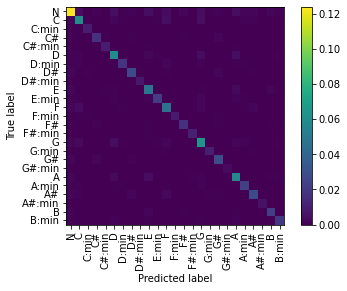

In [ ]:
#!/usr/bin/env python3
# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("./PreprocessedDatasets/Billboard500.ds")
n_samples, n_frames, n_chromas = x.shape
x = x.reshape((n_samples,n_frames,n_chromas,1))
train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=args.test_size, random_state=args.seed)

# Create model
crnn_model = CRNN_1(input_shape=(n_frames, n_chromas, 1), output_classes=25)
 
# Train model
crnn_model.fit(train_x, train_y, dev_x, dev_y, epochs=85)

# Display score
crnn_model.display_training_progress()
print("\n","Dev accuracy: ", "{:.2f}".format(100*crnn_model.score(dev_x, dev_y)), "%", "\n")
crnn_model.display_confusion_matrix(dev_x, dev_y)